<a href="https://colab.research.google.com/github/akin-oladejo/self-driving-modules/blob/main/hough-lane-detection/hough_lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hough Lane Detection
Below is the code to detect lanes in a short driving video recorded on the Lagos-Ibadan Expressway. It uses Canny Edge Detection for line detection and the Hough transform to determine lane lines.

You would probably have to tweak parameters to get the lanes in a different video.

In [ ]:
# install the av backend for imageio
!pip install av array2gif

In [ ]:
# import libraries
import imageio.v3 as iio
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import cv2

%matplotlib inline

In [ ]:
# bulk read all frames
frames = iio.imread("lane_driving.mp4", plugin="pyav")

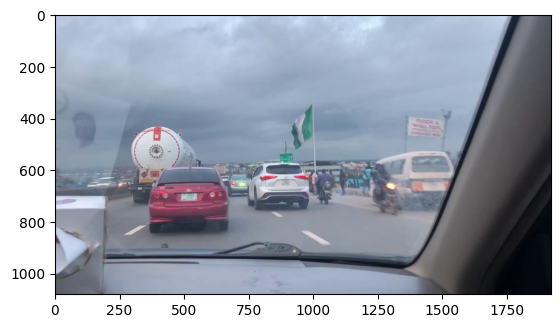

In [ ]:
img = frames[0]
plt.imshow(img)

In [ ]:
def plot_lanes(image,
               canny_low:int = 50,
               canny_high:int = 100,
               kernel_size:int = 5,
               rho:float|int = 1,
               theta:float = np.pi/180,
               hough_threshold:int = 1,
               min_line_length:int = 5,
               max_line_gap:int = 1):
    """
    image. image array

    Canny Edge Detection Parameters
    ====
    canny_low.
    canny_high.

    Hough Transform Parameters
    ====
    rho. distance resolution in pixels of the Hough grid
    theta. angular resolution in radians of the Hough grid
    threshold. minimum number of votes (intersections in Hough grid cell)
    min_line_length. minimum number of pixels making up a line
    max_line_gap. maximum gap in pixels between connectable line segments
    """

    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) # convert image to gray

    # return gray

    # Define a kernel size and apply Gaussian smoothing to remove noise
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # return blur_gray

    # Define our parameters for Canny and apply
    edges = cv2.Canny(blur_gray, canny_low, canny_high)

    # return edges

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)
    ignore_mask_color = 255

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # return edges

    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # # Run Hough on edge detected image
    # # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, hough_threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    return lines_edges
    # plt.imshow(lines_edges)

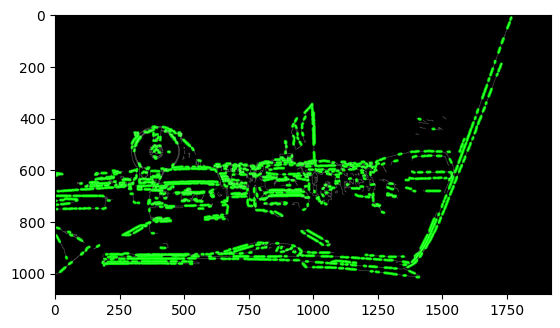

In [ ]:
plt.imshow(plot_lanes(img));

In [ ]:
annotated_frames = np.array(
[plot_lanes(img,
            canny_low=60,
            canny_high=70,
            kernel_size=5,
            rho=1,
            theta=np.pi/180,
            hough_threshold=1,
            min_line_length=5,
            max_line_gap=1) for img in frames], dtype=np.int32)
annotated_frames.shape

(39, 1080, 1920, 3)

In [ ]:
fps = cv2.VideoCapture("lane_driving.mp4").get(cv2.CAP_PROP_FPS) # get fps in original video
fps

30.0

AttributeError: ignored

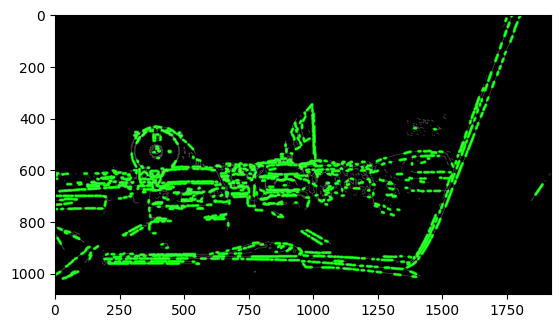

In [ ]:
# Create a figure
fig = plt.figure()

# Define a function to update the image in the figure
def update_image(n):
    plt.imshow(annotated_frames[n])

# Create a writer object
# ffm_writer = animation.FFMpegWriter(fps=30)

# Create an animation object
anim = animation.FuncAnimation(fig, update_image, frames=len(annotated_frames))
anim.save('annotated_lanes.mp4', writer='ffmpeg', fps=30)

# # # converting to an html5 video
# video = anim.to_html5_video()

# # # embedding for the video
# html = display.HTML(video)

# # # draw the animation
# # display.display(html)
# plt.close()

In [ ]:
# height, width, channels = annotated_frames[0].shape

# # create a VideoWriter instance
# video_writer = cv2.VideoWriter('annotated_lane_driving.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
# # video_writer = cv2.VideoWriter('annotated_lane_driving.mp4', cv2.VideoWriter_fourcc(*'mp4v'), , (width, height))

# for frame in annotated_frames.astype(np.uint8):
#     video_writer.write(frame)

# video_writer.release() # Close the VideoWriter object

# cv2.destroyAllWindows()

In [ ]:
from moviepy.editor import ImageSequenceClip

# Create an ImageSequenceClip object
clip = ImageSequenceClip(annotated_frames, fps=30)

# Save the video file
clip.write_videofile('output.mp4', fps=30, codec='mpeg4')

In [ ]:
# method 2
from array2gif import write_gif
write_gif(annotated_frames, 'result.gif', fps=fps)